In [1]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import StrainEnergyCANN_C, StrainEnergyCANN_polinomial3
from sklearn.metrics import r2_score


# Предобработка данных

In [2]:
compr_data_path = r"..\..\data\PDMS\Compression_pdms.csv"
tensl_data_path = r"..\..\data\PDMS\Shear_pdms.csv"
shear_data_path = r"..\..\data\PDMS\Tensile_pdms.csv"
experiments_path = [compr_data_path, tensl_data_path, shear_data_path]

In [3]:
data_frames = [pd.read_csv(file, header=None) for file in experiments_path]
df = pd.concat(data_frames, ignore_index=True)
thinned_data_frames = []
num_points = 100

sampled_df_list = []

for df in data_frames:
    indices = np.linspace(0, len(df) - 1, num_points, dtype=int)
    df[1] = df[1] / 10**6
    sampled_df = pd.DataFrame(df.iloc[indices].copy())
    # print(type(sampled_df))
    sampled_df_list.append(sampled_df)
    # thinned_df = df.iloc[::len(df) // 20, :]  # Выбор каждого 45-го значения
    # thinned_data_frames.append(thinned_df)
data_frames = sampled_df_list

# sampled_df_list[0]


In [4]:
I1_tc = lambda lam: lam ** 2 + 2.0 / lam
I2_tc = lambda lam: 2.0 * lam + 1 / lam ** 2
I1_s = lambda gam: gam ** 2 + 3.0
F_tc = lambda lam: ([lam, 0, 0], [0, lam **(-0.5), 0], [0, 0, lam**(-0.5)])
F_s = lambda gam: ([1., gam, 0], [0, 1., 0], [0, 0, 1.])


In [5]:
mechanical_variables = {
    "I1": [I1_tc, I1_s],
    "I2": [I2_tc, I1_s],
    "F": [F_tc, F_s],
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)

    data_frames[0][variable] = data_frames[0][0].apply(func_calc[0])
    data_frames[1][variable] = data_frames[1][0].apply(func_calc[0])
    data_frames[2][variable]  = data_frames[2][0].apply(func_calc[1])


In [6]:
experiments = ['Compression', 'Tensile', 'Shear']
combined_data = pd.concat([df.assign(Experiment=exp) for df, exp in zip(data_frames, experiments)]).reset_index(drop=True, inplace=False)
combined_data.columns = ['lambda', 'P_experimental', 'I1', 'I2', 'F', 'experiment_type']

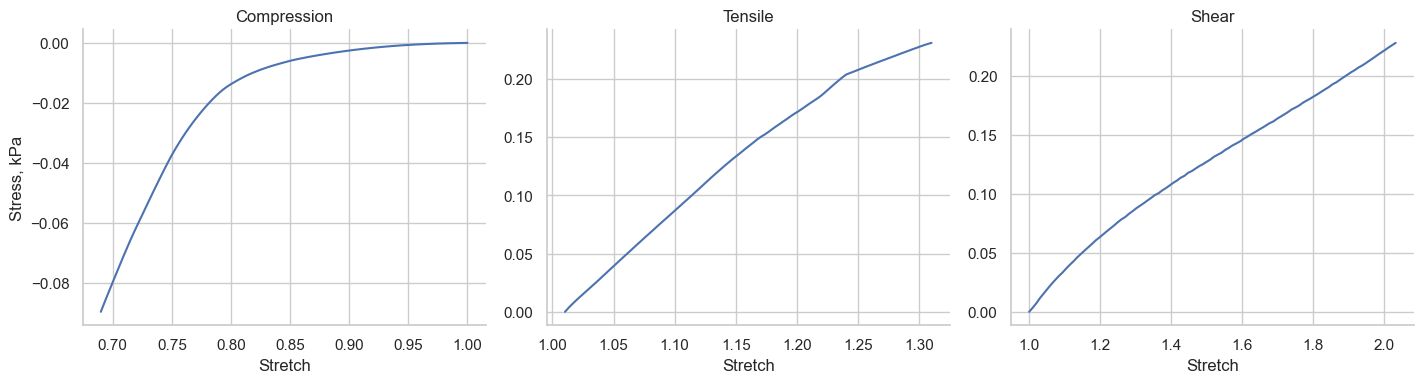

In [7]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=combined_data,
    x='lambda', y='P_experimental', col='experiment_type', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Update axis labels
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")
plt.savefig("PDMS")

plt.show()

In [8]:
combined_data

,lambda,P_experimental,I1,I2,F,experiment_type
0,0.689936,-0.089636,3.374831,3.480661,"([0.689936, 0, 0], [0, 1.2039143658621678, 0],...",Compression
1,0.693003,-0.086563,3.366245,3.468243,"([0.6930026, 0, 0], [0, 1.201247696840051, 0],...",Compression
2,0.696069,-0.083562,3.357790,3.456069,"([0.6960692, 0, 0], [0, 1.1985986696858841, 0]...",Compression
3,0.699136,-0.080606,3.349466,3.444137,"([0.6991357, 0, 0], [0, 1.1959671762634831, 0]...",Compression
4,0.702202,-0.077653,3.341270,3.432440,"([0.7022023, 0, 0], [0, 1.1933528542449536, 0]...",Compression
...,...,...,...,...,...,...
295,1.990134,0.219540,6.960633,6.960633,"([1.0, 1.9901338, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
296,2.000803,0.221600,7.003214,7.003214,"([1.0, 2.0008033, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
297,2.011473,0.223910,7.046023,7.046023,"([1.0, 2.0114728, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
298,2.022142,0.226020,7.089059,7.089059,"([1.0, 2.0221422, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [9]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]][:6])
        target = features.pop(1)

        return features, target

    def to_tensor(self):
        for column in self.data.columns:
            if column != "experiment_type":
                self.data[column] = self.data[column].apply(
                    lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [10]:
# start = 0
# end = 49
# train_dataset = CustomDataset(combined_data[start:end].copy())
# test_dataset = CustomDataset(combined_data.copy())
# f, t = train_dataset[0]
# lam, i1, i2, F, exp_type = f
# print(f)

In [11]:
experiments = ["Shear", "Tensile"]
d = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
d

,lambda,P_experimental,I1,I2,F,experiment_type
0,1.000000,0.000000,4.000000,4.000000,"([1.0, 1.0, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
1,1.009611,0.003250,4.019314,4.019314,"([1.0, 1.0096108, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
2,1.020280,0.007240,4.040972,4.040972,"([1.0, 1.0202803, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
3,1.030950,0.011800,4.062857,4.062857,"([1.0, 1.0309498, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
4,1.041619,0.015700,4.084971,4.084971,"([1.0, 1.0416192, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
...,...,...,...,...,...,...
195,1.297698,0.226308,3.225211,3.189213,"([1.2976981, 0, 0], [0, 0.8778355519819674, 0]...",Tensile
196,1.300701,0.227461,3.229456,3.192480,"([1.3007011, 0, 0], [0, 0.8768216128563897, 0]...",Tensile
197,1.303704,0.228545,3.233735,3.195767,"([1.3037041, 0, 0], [0, 0.8758111790683766, 0]...",Tensile
198,1.306707,0.229569,3.238048,3.199071,"([1.3067071, 0, 0], [0, 0.8748042304669162, 0]...",Tensile


In [12]:
def init_loaders(experiments=["Shear", "Tensile", "Comression"]):
    if type(experiments) == str:
        experiments = [experiments]
    print(experiments)
    
    df = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
    train_dataset = CustomDataset(df.copy())
    test_dataset = CustomDataset(combined_data.copy())
    
    train_dataset.to_tensor()
    test_dataset.to_tensor()
    
    train_data_loader = DataLoader(
                            train_dataset,
                            shuffle=True,
                            # num_workers=1,
                            pin_memory=False
    )
    test_data_loader = DataLoader(
                            test_dataset,
                            shuffle=False,
                            # num_workers=1,
                            pin_memory=False
    )

    return train_data_loader, test_data_loader 

In [13]:
train_data_loader, test_data_loader = init_loaders("Compression")
train_data_loader.dataset.data

['Compression']


,lambda,P_experimental,I1,I2,F,experiment_type
0,tensor(0.6899),tensor(-0.0896),tensor(3.3748),tensor(3.4807),"[[tensor(0.6899), tensor(0.), tensor(0.)], [te...",Compression
1,tensor(0.6930),tensor(-0.0866),tensor(3.3662),tensor(3.4682),"[[tensor(0.6930), tensor(0.), tensor(0.)], [te...",Compression
2,tensor(0.6961),tensor(-0.0836),tensor(3.3578),tensor(3.4561),"[[tensor(0.6961), tensor(0.), tensor(0.)], [te...",Compression
3,tensor(0.6991),tensor(-0.0806),tensor(3.3495),tensor(3.4441),"[[tensor(0.6991), tensor(0.), tensor(0.)], [te...",Compression
4,tensor(0.7022),tensor(-0.0777),tensor(3.3413),tensor(3.4324),"[[tensor(0.7022), tensor(0.), tensor(0.)], [te...",Compression
...,...,...,...,...,...,...
95,tensor(0.9874),tensor(-9.5287e-05),tensor(3.0005),tensor(3.0005),"[[tensor(0.9874), tensor(0.), tensor(0.)], [te...",Compression
96,tensor(0.9905),tensor(-6.9480e-05),tensor(3.0003),tensor(3.0003),"[[tensor(0.9905), tensor(0.), tensor(0.)], [te...",Compression
97,tensor(0.9935),tensor(-4.1975e-05),tensor(3.0001),tensor(3.0001),"[[tensor(0.9935), tensor(0.), tensor(0.)], [te...",Compression
98,tensor(0.9966),tensor(-1.6917e-05),tensor(3.0000),tensor(3.0000),"[[tensor(0.9966), tensor(0.), tensor(0.)], [te...",Compression


# Обучение модели

In [14]:
experiments=[["Shear", "Tensile", "Comression"],["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Comression"]
for experiment in experiments:
    print(experiment)

['Shear', 'Tensile', 'Comression']
['Tensile', 'Comression']
['Tensile', 'Shear']
['Shear', 'Comression']
Shear
Tensile
Comression


In [15]:
# Переименуем столбцы для удобства
# data.columns = ['strain', 'measured_force', 'I1', 'I2', 'F', 'experiment_type', 'predicted_force']

# Удалим ненужные столбцы
# data = data[['strain', 'measured_force', 'experiment_type', 'predicted_force']]
def plot_results(data:pd.DataFrame, plot_name=""):
    # Преобразуем столбец с предсказанной силой в числовой формат
    # data['P_model_' + plot_name] = data['P_model_' + plot_name].apply(lambda x: float(str(x).strip('[]')))
    data['P_model' + plot_name] = data['P_model' + plot_name].apply(lambda x: float(str(x).strip('[]')))
    
    # Создадим графики для каждого типа эксперимента
    experiment_types = data['experiment_type'].unique()
    def plot_with_r2(data, experiment_types):
        r2_scores = []
        fig, axes = plt.subplots(1, len(experiment_types), figsize=(15, 6), sharey=False)
        
        for ax, experiment in zip(axes, experiment_types):
            subset = data[data['experiment_type'] == experiment]
            r2 = r2_score(subset['P_experimental'], subset['P_model' + plot_name])
            # r2 = r2_score(subset['P_experimental'], subset['P_model_' + plot_name])
            
            sns.scatterplot(data=subset, x='lambda', y='P_experimental', label='P_experimental', ax=ax)
            # sns.lineplot(data=subset, x='lambda', y='P_model_' + plot_name, label='P_model', color='orange', ax=ax)
            sns.lineplot(data=subset, x='lambda', y='P_model' + plot_name, label='P_model', color='orange', ax=ax)
            ax.set_title(f'Experiment Type: {experiment}\nR² = {r2:.2f}')
            ax.set_xlabel('Strain')
            ax.set_ylabel('Force (kPa)')
            r2_scores.append(r2)
        
        plt.tight_layout()
        plt.savefig(plot_name)
        plt.show()
        
        return r2_scores
    # Вызовем функцию для построения графиков с r2
    plot_with_r2(data, experiment_types)

In [ ]:
# experiments=[["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Compression"]
experiments = ["Tensile", "Comression", "Shear"]
# models = [StrainEnergyCANN_C, StrainEnergyCANN_polinomial3]
models = [StrainEnergyCANN_C]
path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models"
for model in models:


    # for idx, experiment in enumerate(experiments):
        train_data_loader, test_data_loader = init_loaders()
        name = "PDMS_" + str(model.__name__)
        print("----------------------------------------------------------------------")
        # print(experiment)
        test_train = Trainer(
            plot_valid=False,
            epochs=2500,
            experiment_name=name,
            l2_reg_coeff=None,
            learning_rate=0.001,
            checkpoint=None,
            model=model
            # dtype = torch.float64
        )
        
        trained_model = test_train.train(train_data_loader, None, weighting_data=True)
    
        trained_model.eval()
        vpredictions = []
        vtargets = []
        for data in test_data_loader:
            features, target = data
            vpredictions.append(trained_model(features).detach().numpy())
        print(trained_model.get_potential())
        
        combined_data["P_model_" + name] = vpredictions
        plot_results(combined_data, name)
        combined_data.to_csv(os.path.join(os.path.join(path, str(name)), "data.csv"))
        combined_data.pop("P_model_" + name)
# trained_model = StrainEnergyCANN_C()


# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

# plt.show()

['Shear', 'Tensile', 'Comression']
----------------------------------------------------------------------
Directory pretrained_models\PDMS_StrainEnergyCANN_C already exists


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


------------------------------------------------------------------
Epoch [1/2500], Loss: 0.17633147, Test metric: 0.17633147
psi =   0.000000 * (I1 - 3) \\               + 0.026245 * (e^{  0.000000 * (I1 - 3)} - 1)\\               - 0.025429 * ln(1 - 0.052720 * (I1 - 3)) \\               + 0.000000 * (I1 - 3) ^ 2 \\               + 0.085033 * (e^{  0.000000 * (I1 - 3) ^ 2} - 1)\\               - 0.077004 * ln(1 - 0.046803 * (I1 - 3) ^ 2) \\                               + 0.006244 * (I2 - 3) \\               + 0.046553 * (e^{  0.060594 * (I2 - 3))} - 1)\\               - 0.123550* ln(1 - 0.126146 *  (I2 - 3)) \\               + 0.000000 * (I2 - 3) ^ 2 \\               + 0.132380 * (e^{  0.051048 *(I2 - 3) ^ 2)} - 1)\\               - 0.018332* ln(1 - 0.074555 * (I2 - 3) ^ 2)\\
------------------------------------------------------------------
Epoch [2/2500], Loss: 0.01424132, Test metric: 0.01424132
psi =   0.000000 * (I1 - 3) \\               + 0.026245 * (e^{  0.000000 * (I1 - 3)} - 

In [ ]:
best_model_path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling_old\src\CANN_torch\pretrained_models\PDMS_full\20240522_1306_2681.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)

In [ ]:
best_model_path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling_old\src\CANN_torch\pretrained_models\PDMS_full\20240522_1306_2681.pth"
trained_model = StrainEnergyCANN_C()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)